In [8]:
import itertools
from functools import partial

import geopandas as gpd
import numpy as np
import pandas as pd
import vsketch
from fn.fn import new_savepath
from geodude.intersection import (
    assign_psuedoperiodic_order_to_adjacent_clusters,
    assign_random_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons, find_adjacency_clusters,
    find_contained_polys, find_intersecting_polys, find_parent_polygons,
    find_touching_polys, merge_disjoint_polys, pairwise_partition_polygons)
from geodude.line import bezier_func, dash_linestring
from geodude.ops import buft_fill, make_like
from geodude.parameter import Prm, prms
from geodude.subdivide import (bino_draw, flex_rule_recursive_split,
                               split_along_longest_side_of_min_rectangle,
                               split_poly)
from geodude.utils import (Paper, flatten_geoms, merge_LineStrings,
                           merge_Polygons)
from matplotlib import pyplot as plt
from shapely import is_valid, unary_union
from shapely.geometry import (LineString, MultiLineString, MultiPoint,
                              MultiPolygon, Point, Polygon, box)
from shapely.ops import nearest_points

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [4]:
phi = (1 + 5 ** 0.5) / 2
xgen = Prm(1/phi)

split_func = partial(split_along_longest_side_of_min_rectangle, xgen=xgen)

continue_func = partial(bino_draw, p_continue=0.85)

<Axes: >

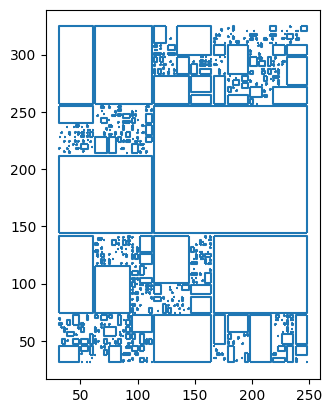

In [5]:
polys = flex_rule_recursive_split(poly=drawbox, split_func=split_func, continue_func=continue_func, depth=0, depth_limit=14)
gdf = gpd.GeoDataFrame(geometry=polys)

gdf.geometry = gdf.geometry.buffer(-1)
gdf = gdf[~gdf.geometry.is_empty]
gdf.boundary.plot()

In [82]:
drawbox.bounds

(30.0, 30.0, 249.39999999999998, 325.59999999999997)

In [6]:
effective_drawbox = box(*unary_union(gdf.geometry).bounds)

In [7]:
n_centers = 3
center_ys = np.linspace(100, 300, n_centers)
center_xs = np.linspace(60, 220, n_centers)
radii = np.random.uniform(75, 170, n_centers)
thickness = np.random.uniform(1, 7, n_centers)

circles = [Point(x, y).buffer(r, resolution=64) for x, y, r in zip(center_xs, center_ys, radii)]
rings = [c.boundary.buffer(thickness).intersection(effective_drawbox) for c, thickness in zip(circles, thickness)]

<Axes: >

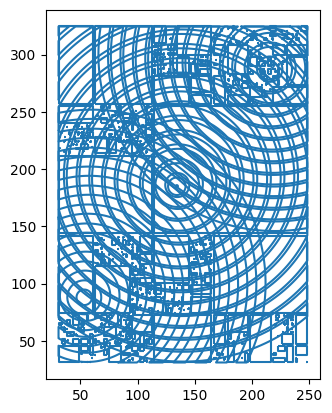

In [9]:
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-20, -10))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)
buffed_fills = [f.buffer(t).intersection(effective_drawbox) for f, t in zip(fills, thickness)]
combined = pd.concat([gdf, flatten_geoms(buffed_fills)]).explode(index_parts=False).reset_index(drop=True)
combined.boundary.plot()

In [10]:
disjoint = chunked_pairwise_partition_polygons(
    combined, 
    chunk_size=10,
    min_area=1e-3,
    )

In [11]:
disjoint = find_parent_polygons(disjoint=disjoint, original=combined)
disjoint = assign_random_order_to_adjacent_clusters(disjoint)

In [12]:
ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-2
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

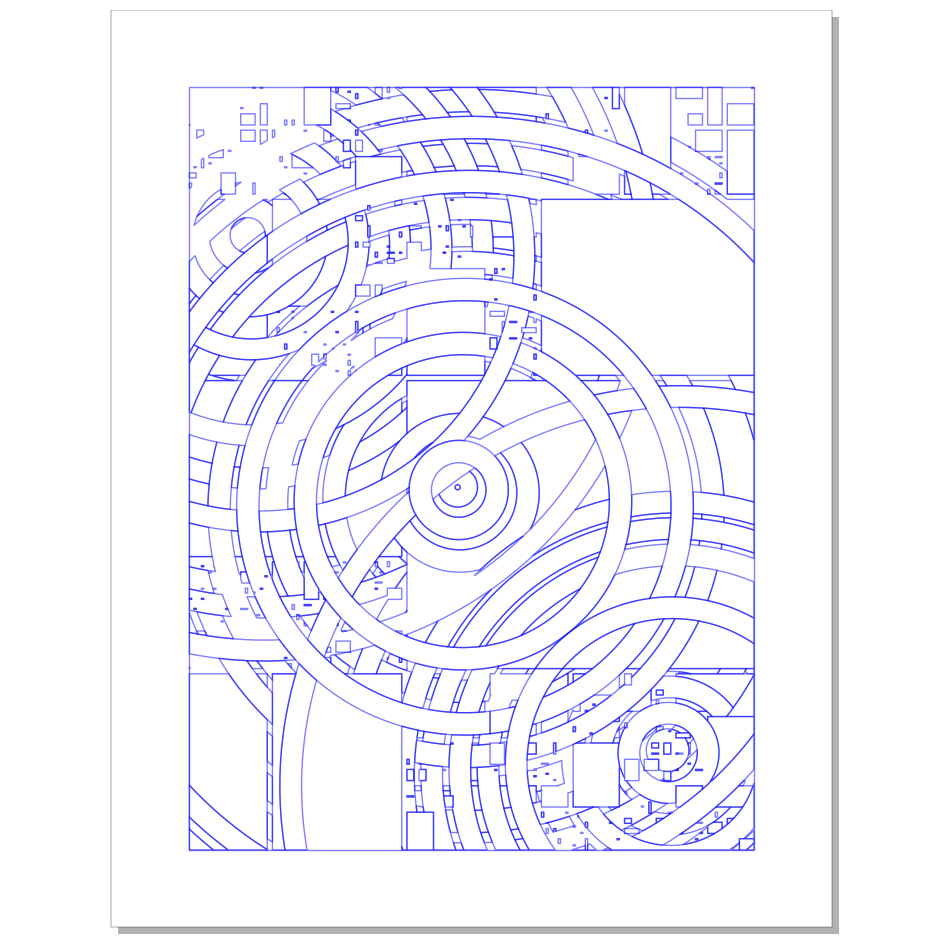

In [13]:
ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.sample(frac=0.8, replace=False).geometry if p.boundary is not None]
mls = merge_LineStrings(lss + [effective_drawbox.boundary])


sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))

In [14]:
sk.vpype('splitall linemerge linesort')

In [15]:
fp = new_savepath(postfix='circles_and_subdivides')
sk.save(fp)

# with fills

In [298]:
# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [299]:
phi = (1 + 5 ** 0.5) / 2
xgen = Prm(1/phi)

split_func = partial(split_along_longest_side_of_min_rectangle, xgen=xgen)

continue_func = partial(bino_draw, p_continue=0.85)

<Axes: >

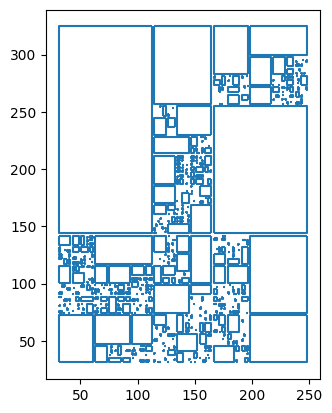

In [328]:
polys = flex_rule_recursive_split(poly=drawbox, split_func=split_func, continue_func=continue_func, depth=0, depth_limit=14)
gdf = gpd.GeoDataFrame(geometry=polys)

gdf.geometry = gdf.geometry.buffer(-1)
gdf = gdf[~gdf.geometry.is_empty]
gdf.boundary.plot()

In [329]:
effective_drawbox = box(*unary_union(gdf.geometry).bounds)

<Axes: >

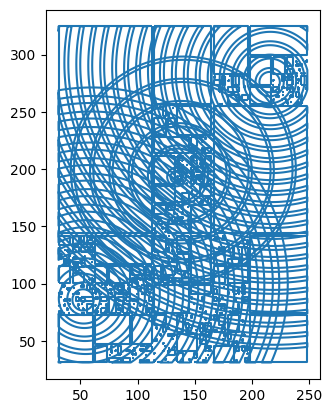

In [350]:
n_centers = 3
center_ys = np.linspace(100, 300, n_centers)
center_xs = np.linspace(60, 220, n_centers)
radii = np.random.uniform(75, 270, n_centers)
thickness = np.random.uniform(1, 5, n_centers)

circles = [Point(x, y).buffer(r, resolution=64) for x, y, r in zip(center_xs, center_ys, radii)]
rings = [c.boundary.buffer(thickness).intersection(effective_drawbox) for c, thickness in zip(circles, thickness)]
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-20, -10))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)
buffed_fills = [f.buffer(t).intersection(effective_drawbox) for f, t in zip(fills, thickness)]
combined = pd.concat([gdf, flatten_geoms(buffed_fills).explode(index_parts=False)]).reset_index(drop=True)
combined.boundary.plot()

In [ ]:
disjoint = chunked_pairwise_partition_polygons(
    combined, 
    chunk_size=10,
    min_area=1e-3,
    )

In [352]:
disjoint = find_parent_polygons(disjoint=disjoint, original=combined)
disjoint = assign_random_order_to_adjacent_clusters(disjoint)

In [353]:
ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-4
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

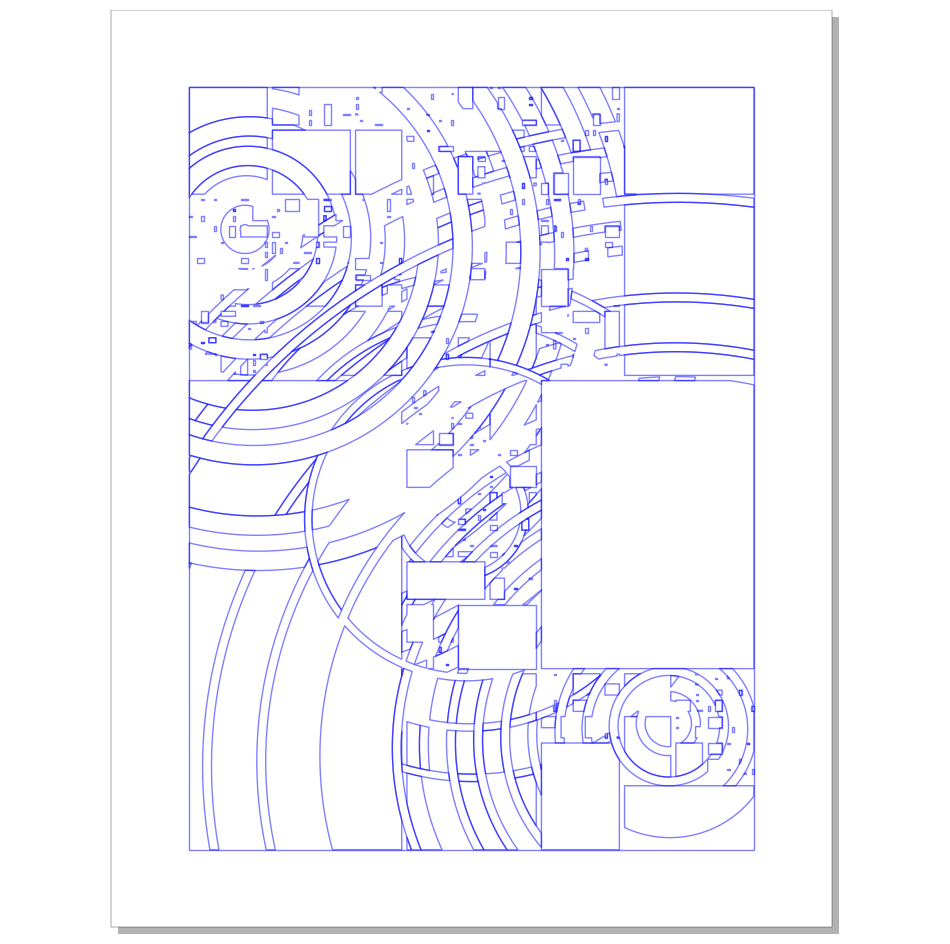

In [374]:
ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.sample(frac=0.6, replace=False).geometry if p.boundary is not None]
mls = merge_LineStrings(lss + [effective_drawbox.boundary])


sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))

In [ ]:
sk.vpype('splitall linemerge linesort')

In [ ]:
fp = new_savepath(postfix='circles_and_subdivides')
sk.save(fp)

In [16]:
sampled_ngdf = ngdf.sample(frac=0.9, replace=False)
sampled_ngdf.boundary.plot()

In [18]:
ngdf

,parent,geometry,area
0,0,"POLYGON ((183.504 47.473, 183.503 47.473, 183....",0.967062
1,6,"POLYGON ((191.060 47.473, 191.059 47.473, 191....",0.357472
2,7,"POLYGON ((178.833 57.654, 178.832 57.654, 178....",216.982445
3,8,"POLYGON ((166.608 53.261, 166.608 53.261, 166....",19.923552
4,8,"POLYGON ((166.609 63.950, 166.608 63.950, 166....",20.181584
...,...,...,...
719,547,"POLYGON ((208.615 263.094, 208.615 263.094, 20...",249.934651
720,547,"POLYGON ((242.588 299.929, 242.587 299.930, 24...",2.254538
721,547,"POLYGON ((219.805 318.740, 219.805 318.740, 21...",54.913897
722,548,"POLYGON ((198.588 296.790, 198.588 296.791, 19...",705.421476


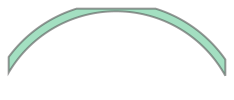

In [19]:
geom

In [41]:
fills = []
for geom in combined.geometry:
    d_buffer = Prm(np.random.uniform(-0.5, -0.1))
    d_translate = Prm(lambda : d_buffer() * np.random.uniform(0.1, 0.9))
    deg = Prm(np.random.uniform(15, 130))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)

In [42]:
fill_gdf = gpd.GeoDataFrame(geometry=fills)

In [29]:
fill_gdf = flatten_geoms(fills, as_gdf = True)

In [44]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = sampled_ngdf.query('parent == @ii').geometry.buffer(1e-6)
    masked.append(fill.intersection(mask))
masked = pd.concat(masked)
masked = masked[~masked.is_empty]
fill_mls = merge_LineStrings(masked.to_list())

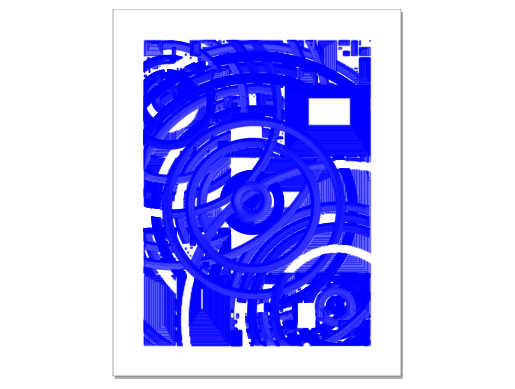

In [45]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(fill_mls, drawbox))
sk.display()

In [46]:
sk.vpype('splitall linemerge linesort')

In [47]:
fp = new_savepath(postfix='circles_and_subdivides_filled')
sk.save(fp)